In [1]:
# This Python 3 environment comes with many helpful analytics libraries installedimport numpy as np # linear algebra
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch as tch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

import os
print(os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"))

device = tch.device("cuda:0" if tch.cuda.is_available() else "cpu")
print("Current  Device:",device)

['Uninfected', 'Parasitized']
Current  Device: cuda:0


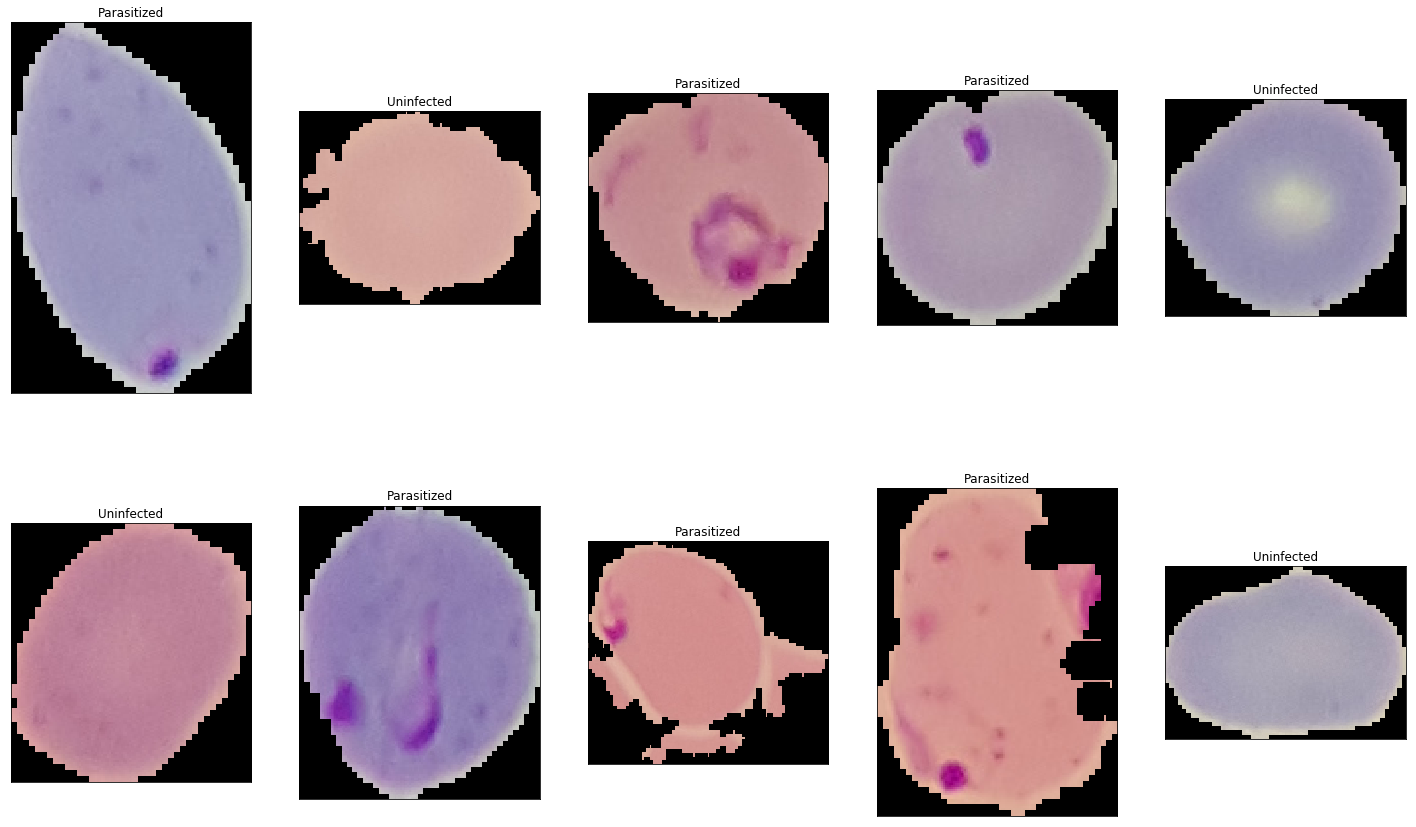

In [2]:
image_folder = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"

#Define Classes for the title
classes= ['Parasitized', 'Uninfected']
#Import the images data with just Tensor Transformation for viewing the images
image_data = datasets.ImageFolder(root=image_folder,transform = transforms.ToTensor())

#Create a place holder for images and labels to study
image_list= []
title_list = []

#Create a random list if Prasitized nad Uninfected (limiting samples to 10)
np.random.seed(2019)
for i in np.random.choice(range(1,len(image_data)),10):
    image_list.append(image_data[i][0].numpy().transpose())
    title_list.append(classes[image_data[i][1]])

fig = plt.figure(figsize=(25, 15))
for i,(image,title) in enumerate(zip(image_list,title_list)):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=title)
    plt.imshow(image)
plt.show()    


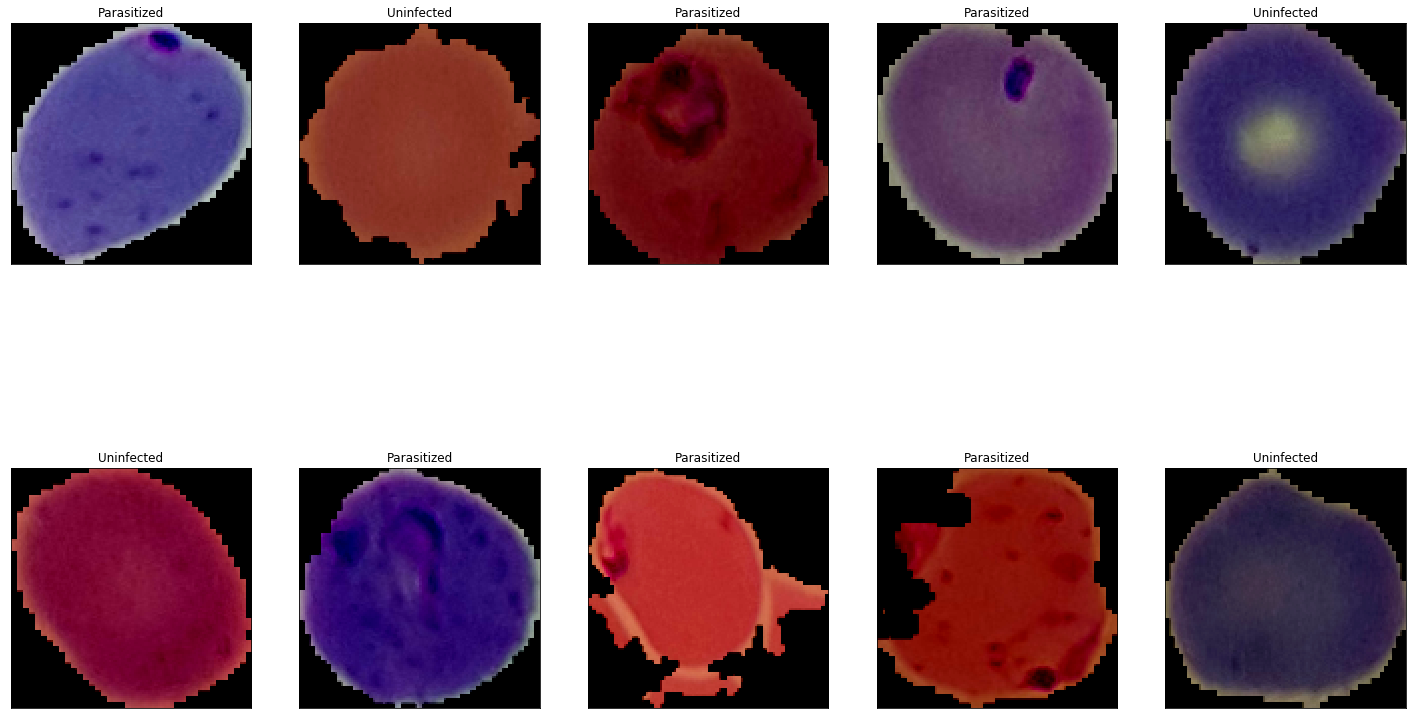

In [3]:
#Import the images data with just Tensor Transformation for viewing the images
transformation  = transforms.Compose([transforms.Resize((120,120)),
                                     transforms.ColorJitter(0.1),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


image_data = datasets.ImageFolder(root=image_folder,transform = transformation)

#Create a place holder for images and labels to study
image_list= []
title_list = []

#Create a random list if Prasitized nad Uninfected (limiting samples to 10)
np.random.seed(2019)
for i in np.random.choice(range(1,len(image_data)),10):
    image_list.append(image_data[i][0].numpy().transpose())
    title_list.append(classes[image_data[i][1]])

fig = plt.figure(figsize=(25, 15))
for i,(image,title) in enumerate(zip(image_list,title_list)):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=title)
    plt.imshow(image)
plt.show()    

In [4]:
len(image_data)

27558

In [5]:
import torch.nn as nn
import torch.nn.functional as F

model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.6MB/s]


In [6]:
model.fc 

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
model.fc = nn.Linear(512,2)

In [8]:
model.to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
#Using Adam Optimization
optimizer = tch.optim.Adam(model.parameters(),lr= learning_rate)

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

test_size= 0.2
samples = len(image_data)
indices = list(range(samples))
np.random.shuffle(indices)
train_len  =  int(np.floor(samples * (1-test_size)))
train_index, test_index = indices[:train_len], indices[train_len:]

train_sampler,test_sampler = SubsetRandomSampler(train_index),SubsetRandomSampler(test_index)

train_loader = DataLoader(image_data,sampler= train_sampler,batch_size = 64)
test_loader = DataLoader(image_data, sampler= test_sampler,batch_size = 64, )

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss= 0.0
    #Explicitly start model training
    model.train()
    
    for i, (images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        input_data = images.view(-1,3,120,120)
        output_data  = model(input_data)
        
        optimizer.zero_grad()
        loss = loss_function(output_data, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * 64 #batch_size for train
        
    print("Epoch: {} - Loss:{:.4f}".format(epoch+1,train_loss / len(train_loader.dataset)))

Epoch: 1 - Loss:0.1146
Epoch: 2 - Loss:0.0908
Epoch: 3 - Loss:0.0831
Epoch: 4 - Loss:0.0817
Epoch: 5 - Loss:0.0765
Epoch: 6 - Loss:0.0761
Epoch: 7 - Loss:0.0720
Epoch: 8 - Loss:0.0693
Epoch: 9 - Loss:0.0685
Epoch: 10 - Loss:0.0661


In [12]:
tch.save(model.state_dict(), "Resnet_Adam.pytorch")

In [13]:
sample_model = model
sample_model.load_state_dict(tch.load("Resnet_Adam.pytorch"))
sample_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with tch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        actual.extend(labels.data.tolist())

        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = tch.max(outputs, 1)[1]
        predict.extend(predicted.data.tolist())

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, f1_score

print(confusion_matrix(actual,predict))
print("Accuracy =",accuracy_score(actual,predict))
print("Precision =",precision_score(actual,predict))
print("Recall =",recall_score(actual,predict))
print("F1 Score =",f1_score(actual,predict))

[[2622  124]
 [  62 2704]]
Accuracy = 0.966255442670537
Precision = 0.9561527581329562
Recall = 0.9775849602313811
F1 Score = 0.9667500893814802
